In [59]:


%matplotlib inline

import pandas as pd
import os
import seaborn as sns
import numpy as np

In [60]:
SM_BASE_TRAIN = '/kaggle/input/freud-detect/PS_20174392719_1491204439457_log.csv'

df = pd.read_csv(SM_BASE_TRAIN)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [61]:
df_dataset = df.copy()
df_dataset['hour'] = (df_dataset.step % 24)
df_dataset['dayOfMonth'] = (df_dataset.step // 24) + 1
df_dataset['signal'] = df_dataset.type.apply(lambda x: -1 if x == 'CASH_IN' else 1)
df_dataset['currbalanceDest'] = df_dataset.oldbalanceDest + (df_dataset.signal * df_dataset.amount)
df_dataset['isMerchantDest'] = df_dataset.nameDest.apply(lambda x: 1 if x.startswith('M') else 0)

df_dataset.type = df_dataset.type.astype('category').cat.codes

## After some analysis we can say that there are errors related to the balance 
## of both accounts after the transaction. Let's try to evidence it to the model
df_dataset['errorBalanceOrig'] = df_dataset.newbalanceOrig + df_dataset.amount - df_dataset.oldbalanceOrg
df_dataset['errorBalanceDest'] = df_dataset.oldbalanceDest + df_dataset.amount - df_dataset.newbalanceDest

df_dataset = df_dataset.drop(columns=['step', 'nameOrig', 'nameDest', 'isFlaggedFraud', 'currbalanceDest', 'signal']).fillna(0)

df_dataset.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,hour,dayOfMonth,isMerchantDest,errorBalanceOrig,errorBalanceDest
0,3,9839.64,170136.0,160296.36,0.0,0.0,0,1,1,1,0.0,9839.64
1,3,1864.28,21249.0,19384.72,0.0,0.0,0,1,1,1,0.0,1864.28
2,4,181.00,181.0,0.00,0.0,0.0,1,1,1,0,0.0,181.00
3,1,181.00,181.0,0.00,21182.0,0.0,1,1,1,0,0.0,21363.00
4,3,11668.14,41554.0,29885.86,0.0,0.0,0,1,1,1,0.0,11668.14


In [62]:

df_dataset[['isFraud', 'amount']].groupby(['isFraud']).count()

,amount
isFraud,
0,6354407
1,8213


<Axes: >

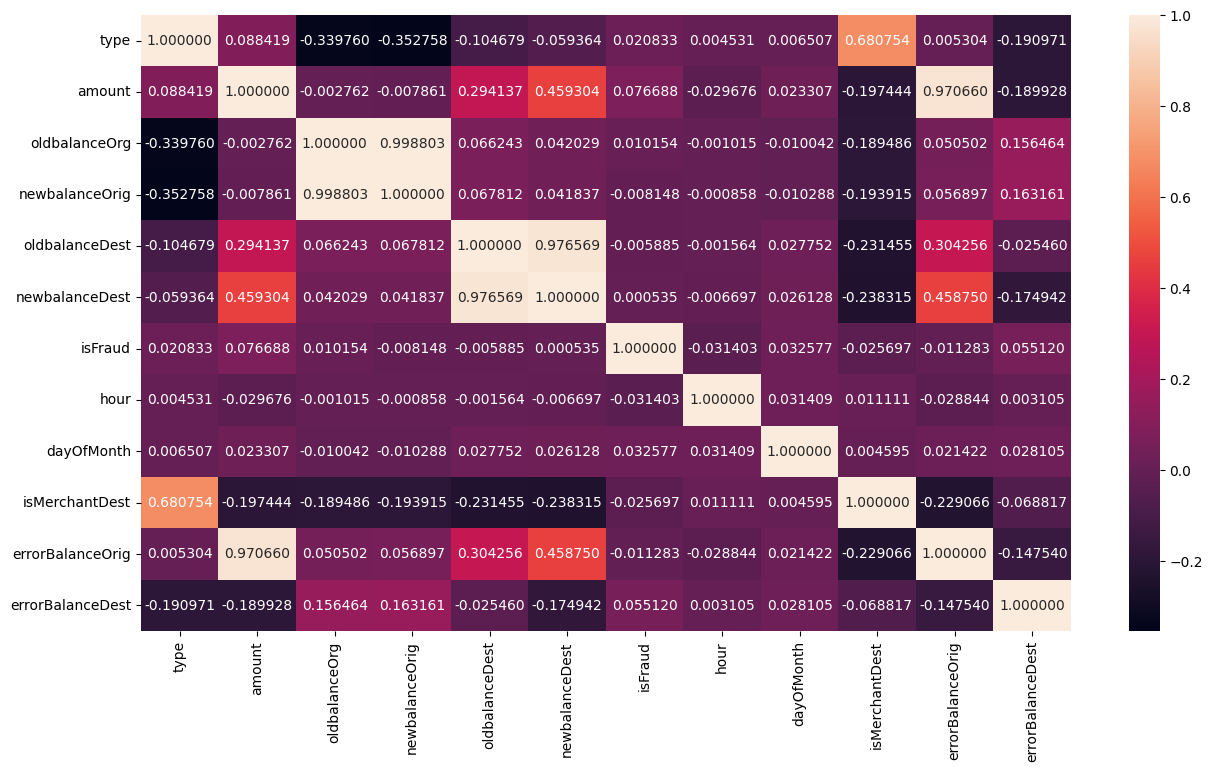

In [63]:
import matplotlib.pyplot as plt
corr = df_dataset.corr()

f, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(corr, annot=True, fmt="f",
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            ax=ax)

In [64]:
train_data = df_dataset[[
    'isFraud', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',    
    'newbalanceDest', 'hour', 'dayOfMonth', 'isMerchantDest',
        'errorBalanceOrig', 'errorBalanceDest' 
]].copy()

In [65]:
train_data

,isFraud,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,hour,dayOfMonth,isMerchantDest,errorBalanceOrig,errorBalanceDest
0,0,3,9839.64,170136.00,160296.36,0.00,0.00,1,1,1,0.0,9.839640e+03
1,0,3,1864.28,21249.00,19384.72,0.00,0.00,1,1,1,0.0,1.864280e+03
2,1,4,181.00,181.00,0.00,0.00,0.00,1,1,0,0.0,1.810000e+02
3,1,1,181.00,181.00,0.00,21182.00,0.00,1,1,0,0.0,2.136300e+04
4,0,3,11668.14,41554.00,29885.86,0.00,0.00,1,1,1,0.0,1.166814e+04
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,1,1,339682.13,339682.13,0.00,0.00,339682.13,23,31,0,0.0,0.000000e+00
6362616,1,4,6311409.28,6311409.28,0.00,0.00,0.00,23,31,0,0.0,6.311409e+06
6362617,1,1,6311409.28,6311409.28,0.00,68488.84,6379898.11,23,31,0,0.0,1.000000e-02
6362618,1,4,850002.52,850002.52,0.00,0.00,0.00,23,31,0,0.0,8.500025e+05


In [66]:
import joblib
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight

def load_data(train_data):
    # train_data = pd.read_csv(data_dir)
     # labels are in the first column
    train_y = train_data.iloc[:, 0].values
    train_X = train_data.iloc[:, 1:].values
    return train_y, train_X


In [67]:
load_data(train_data)

(array([0, 0, 1, ..., 1, 1, 1], dtype=int64),
 array([[3.00000000e+00, 9.83964000e+03, 1.70136000e+05, ...,
         1.00000000e+00, 0.00000000e+00, 9.83964000e+03],
        [3.00000000e+00, 1.86428000e+03, 2.12490000e+04, ...,
         1.00000000e+00, 0.00000000e+00, 1.86428000e+03],
        [4.00000000e+00, 1.81000000e+02, 1.81000000e+02, ...,
         0.00000000e+00, 0.00000000e+00, 1.81000000e+02],
        ...,
        [1.00000000e+00, 6.31140928e+06, 6.31140928e+06, ...,
         0.00000000e+00, 0.00000000e+00, 9.99999978e-03],
        [4.00000000e+00, 8.50002520e+05, 8.50002520e+05, ...,
         0.00000000e+00, 0.00000000e+00, 8.50002520e+05],
        [1.00000000e+00, 8.50002520e+05, 8.50002520e+05, ...,
         0.00000000e+00, 0.00000000e+00, 9.31322575e-10]]))

In [68]:
from sklearn.metrics import accuracy_score

In [69]:
def train_model(**args):
    kf = StratifiedKFold(n_splits=args['k_fold_splits'], shuffle=True, random_state=42)
    y,X = load_data(args['train'])
    cw = compute_class_weight('balanced', classes=np.unique(y), y=y)
    best = 0
    iteration = 0
    
    for train_index, test_index in kf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
       
        print("Training...")

        model = RandomForestClassifier(
            n_estimators=args['n_estimators'], verbose=args['verbose'], 
            n_jobs=-1, criterion='gini', max_leaf_nodes=args['max_leaf_nodes'], 
            max_depth=args['max_depth'], random_state=0, class_weight={0: cw[0], 1:cw[1]}
        )
        
        model.fit(X_train, y_train)
        print("Done! Computing scores...")        
        testing =model.predict(X_test)
        train_score = f1_score(y_train, model.predict(X_train))
        test_score = f1_score(y_test, testing)
        print("Iteration=%d; train_f1=%f; test_f1=%f;" % (iteration, train_score, test_score))
        
        if test_score > best:            
            best = test_score
            print("Saving checkpoint for best model: best_f1=%f;" % best)
            joblib.dump(model, os.path.join(args['output_data_dir'], "/kaggle/working/output-model/best_model.joblib"))
        
        iteration += 1
    print("\nSaving the best model: best_f1=%f;" % best)
    return testing,y_test

In [70]:
SM_MODEL_DIR = '../output-model'

# Hyperparameters are described here. In this simple example we are just including one hyperparameter.    
n_estimators = 30
max_depth = 10
max_leaf_nodes = -1
k_fold_splits = 2
verbose = 1

In [71]:
import os

# Define the directory name
directory_name = "/kaggle/working/output-model"

# Create the directory
os.makedirs(directory_name, exist_ok=True)

print(f"Directory '{directory_name}' created successfully!")


Directory '/kaggle/working/output-model' created successfully!


In [72]:
pred,true=train_model(n_estimators=30, k_fold_splits=2, verbose=1, max_depth=10,max_leaf_nodes = 2, train=train_data, output_data_dir=SM_MODEL_DIR)

Training...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   25.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Done! Computing scores...


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    1.6s finished


Iteration=0; train_f1=0.012491; test_f1=0.012499;
Saving checkpoint for best model: best_f1=0.012499;
Training...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   25.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Done! Computing scores...


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    1.6s finished


Iteration=1; train_f1=0.018076; test_f1=0.018053;
Saving checkpoint for best model: best_f1=0.018053;

Saving the best model: best_f1=0.018053;


In [73]:
model = joblib.load('/kaggle/working/output-model/best_model.joblib')

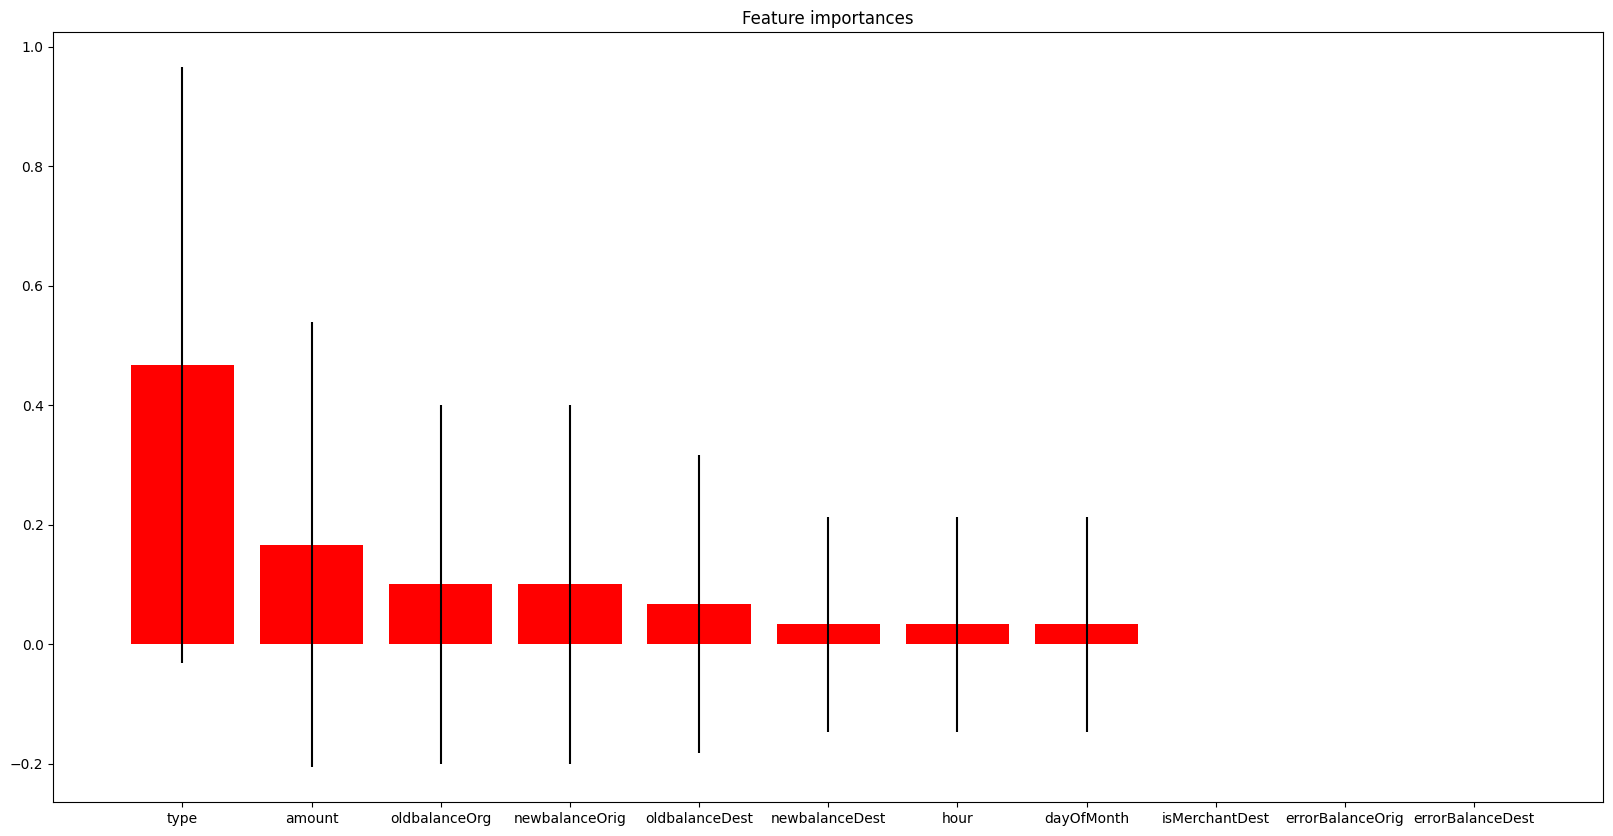

In [74]:
import matplotlib.pyplot as plt

importances = model.feature_importances_

std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
labels = np.array(['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',    
    'newbalanceDest', 'hour', 'dayOfMonth', 'isMerchantDest',
        'errorBalanceOrig', 'errorBalanceDest'])

# Print the feature ranking
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(labels[indices], importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(indices, labels[indices])
plt.xlim([-1, len(indices)])
plt.show()

In [75]:
y,X = load_data(train_data)


In [76]:
%%time
import random

num_elements = 1
iterations = 1
correct_predictions = 1

for i in range(iterations):
  idx = random.randint(0, len(X)-num_elements)
  y_test, X_test = y[idx:idx+num_elements], X[idx:idx+num_elements]
  preds = model.predict(X_test)
  print(preds)
  correct_predictions += np.sum(np.equal(y_test, preds))

[0]
CPU times: user 12 ms, sys: 4.12 ms, total: 16.2 ms
Wall time: 17.7 ms


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished


In [77]:
print("Correct Predictions: %d/%d" % (correct_predictions, iterations*num_elements ))

Correct Predictions: 2/1


In [78]:
import numpy as np

In [79]:
np.mean(pred==true)

0.8603172906758536

In [80]:
test1=[[3.0,1864.28,21249.0,19384.72,0.0,0.0,1.0,1.0,1.0,0.0,1864.28]]

In [81]:

def prediction(X_test):
    
    x=model.predict(X_test)

    if x == 1:
        print('It is Fraud')
    else:
        print('It is not Fraud')



In [82]:
test2=[[6.0,1864.28,212.0,19000.72,1.0,1.0,1.0,1.0,1.0,1.0,1000.28]]

In [83]:
print('RESULTS_ _ _ _ _')
print('\n')
prediction(test1)
prediction(test2)
##print('\n')
print('_ _ _ _ _')
print('\n')

RESULTS_ _ _ _ _


It is Fraud
It is not Fraud
_ _ _ _ _




[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished


In [84]:
from sklearn.metrics import confusion_matrix

In [85]:
pd.crosstab(true,pred)

col_0,0,1
row_0,,
0,2732851,444352
1,22,4085


In [86]:
conf=confusion_matrix(true,pred)

In [87]:
conf[0][1]*100/len(true)

13.967579393394544

In [88]:
import pandas as pd 

# **Balancing clsses**

In [89]:
rows_limited_1 = df_dataset[df_dataset['isFraud']==1]

In [90]:
rows_limited = df_dataset[df_dataset['isFraud']==0]

In [91]:
rows_limited=rows_limited[:8213]

In [101]:
df_new=pd.concat([rows_limited, rows_limited_1])

In [102]:
df_new[['isFraud', 'amount']].groupby(['isFraud']).count()

,amount
isFraud,
0,8213
1,8213


In [108]:
train_data_new=df_new[[
    'isFraud', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',    
    'newbalanceDest', 'hour', 'dayOfMonth', 'isMerchantDest',
        'errorBalanceOrig', 'errorBalanceDest' 
]].copy()

In [109]:
pred,true=train_model(n_estimators=30, k_fold_splits=2, verbose=1, max_depth=10,max_leaf_nodes = 2, train=train_data_new, output_data_dir=SM_MODEL_DIR)

Training...
Done! Computing scores...
Iteration=0; train_f1=0.992642; test_f1=0.992887;
Saving checkpoint for best model: best_f1=0.992887;
Training...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Done! Computing scores...
Iteration=1; train_f1=0.993010; test_f1=0.992642;

Saving the best model: best_f1=0.992887;


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished


In [110]:
conf=confusion_matrix(true,pred)

In [111]:
fpositive=conf[0][1]*100/len(true)
fpositive

0.0

In [112]:
np.mean(pred==true)

0.9926945087057104